# Part 2: LSTM, GRU, CNN

This is 2nd-part in a 3-parts series: build out 7 neural-nets with hyperparameter-tuning, to identify the best machine-learing model for a sarcasm detector.
1. Project sentences into Vector aka Embedding 
2. Compare 6 neural-nets, along with hyperparameter tuning to determine the best/7th model: stacked LSTMs
3. Incorporate a pretained 27-billion token, 1.2-million word vocab in 25 dimensions from Twitter crawl of 2 billion Tweets
4. Visualization through Google Projector 

## 0. Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. Build "Stopwords"

Just like TF/IDF days, where frequency of words may be inversely related to the importance ... anyone remember LDA, hehe.  

In [2]:
from bs4 import BeautifulSoup
import string

stopwords_list = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

# Create the mapping table to use in translate()
stopwords_table = str.maketrans('', '', string.punctuation)

## 2. Process "sarcasm.json" file 

Sarcasm data provided by Laurency Moroney https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

Data looks like this

In [3]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

print("records total", len(datastore))

records total 26709


### 2.1. Load sentences, cleaning text and exclude "stopwords"

In [4]:
sentences = [] 
labels = []
urls = []

for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(stopwords_table) #replace specified characters with the character described the mapping table
        if word not in stopwords_table:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

### 2.2. Sample data

In [5]:
print("The length of list is: ", len(sentences))

# Show the last N elements
N = 10
print("The last", N, "elements of list are : ", str(sentences[-N:]), "elements of label are : ", str(labels[-N:]))

The length of list is:  26709
The last 10 elements of list are :  ['what you should buy your basic friend  according to pinterest ', 'whats in your mailbox tips on what to do when uncle sam comes knocking ', 'paul ryan is more of a con man than ever ', 'pentagon to withhold budget figures out of respect for american families ', 'pope francis wearing sweater vestments he got for christmas ', 'american politics in moral free  fall ', 'americas best 20 hikes ', 'reparations and obama ', 'israeli ban targeting boycott supporters raises alarm abroad ', 'gourmet gifts for the foodie 2014 '] elements of label are :  [0, 0, 0, 1, 1, 0, 0, 0, 0, 0]


### 2.3. Train/split

In [6]:
training_size = 23000
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

### 2.4. Sentenses into sequences with Tokenizer, Padding and "Out-of-Vocabulary" tokens

In [7]:
vocab_size = 10000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
word_count = tokenizer.word_counts
##print(word_count)
print(len(word_index))

max_length = 100
trunc_type='post'
padding_type='post'

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

24437


### 2.5. Convert to Numpy

In [8]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### 2.6. Helper function for ploting 

In [9]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Model 3: LSTM   

Where the order of the tokens is important, like ... in languages.

Specifically, we are implementing a bi-directional LSTM.  

In [10]:
# Set model-parameters
embedding_dim = 16
dense_dim = 6

num_epochs = 30
BATCH_SIZE = 128

In [11]:
lstm_dim = 32

lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm_history = lstm_model.fit(training_padded, training_labels, epochs=num_epochs, batch_size=BATCH_SIZE,
                              validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
180/180 - 20s - loss: 0.5139 - accuracy: 0.7232 - val_loss: 0.3450 - val_accuracy: 0.8520 - 20s/epoch - 110ms/step
Epoch 2/30
180/180 - 13s - loss: 0.2662 - accuracy: 0.8916 - val_loss: 0.3291 - val_accuracy: 0.8566 - 13s/epoch - 71ms/step
Epoch 3/30
180/180 - 13s - loss: 0.1907 - accuracy: 0.9279 - val_loss: 0.3521 - val_accuracy: 0.8606 - 13s/epoch - 73ms/step
Epoch 4/30
180/180 - 13s - loss: 0.1486 - accuracy: 0.9449 - val_loss: 0.3926 - val_accuracy: 0.8563 - 13s/epoch - 73ms/step
Epoch 5/30
180/180 - 13s - loss: 0.1107 - accuracy: 0.9617 - val_loss: 0.4483 - val_accuracy: 0.8539 - 13s/epoch - 75ms/step
Epoch 6/30
180/180 - 13s - loss: 0.0888 - accuracy: 0.9711 - val_loss: 0.4957 - val_accuracy: 0.8496 - 13s/epoch - 74ms/step
Epoch 7/30
180/180 - 13s - loss: 0.0622 - accuracy: 0.9806 - val_loss: 0.5848 - val_accuracy: 0.8415 - 13s/epoch - 71ms/step
Epoch 8/30
180/180 - 13s - loss: 0.0438 - accuracy: 0.9876 - val_loss: 0.6827 - val_accuracy: 0.8382 - 13s/epoch - 71ms/step

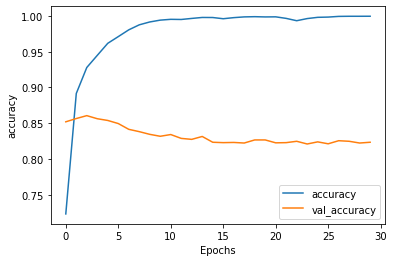

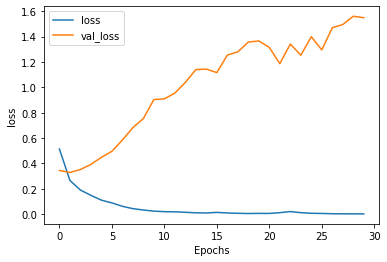

In [13]:
plot_graphs(lstm_history, "accuracy")
plot_graphs(lstm_history, "loss")

# Model 4: GRU

Gated Recurrent Unit (GRU) is usually referred to as a simpler version of the LSTM. 

It is a bit smaller than the LSTM (see model summary) and therefore, usually trains slightly faster but may sacrifice some accuracy. 

In [14]:
gru_dim = 32

gru_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


In [15]:
gru_history = gru_model.fit(training_padded, training_labels, epochs=num_epochs, batch_size=BATCH_SIZE,
                              validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
180/180 - 21s - loss: 0.4974 - accuracy: 0.7369 - val_loss: 0.3399 - val_accuracy: 0.8571 - 21s/epoch - 114ms/step
Epoch 2/30
180/180 - 15s - loss: 0.2570 - accuracy: 0.8941 - val_loss: 0.3427 - val_accuracy: 0.8533 - 15s/epoch - 86ms/step
Epoch 3/30
180/180 - 16s - loss: 0.1912 - accuracy: 0.9257 - val_loss: 0.3700 - val_accuracy: 0.8496 - 16s/epoch - 91ms/step
Epoch 4/30
180/180 - 14s - loss: 0.1479 - accuracy: 0.9463 - val_loss: 0.4221 - val_accuracy: 0.8434 - 14s/epoch - 76ms/step
Epoch 5/30
180/180 - 14s - loss: 0.1189 - accuracy: 0.9587 - val_loss: 0.5023 - val_accuracy: 0.8301 - 14s/epoch - 76ms/step
Epoch 6/30
180/180 - 14s - loss: 0.0952 - accuracy: 0.9677 - val_loss: 0.5573 - val_accuracy: 0.8404 - 14s/epoch - 75ms/step
Epoch 7/30
180/180 - 14s - loss: 0.0726 - accuracy: 0.9751 - val_loss: 0.6353 - val_accuracy: 0.8404 - 14s/epoch - 75ms/step
Epoch 8/30
180/180 - 14s - loss: 0.0547 - accuracy: 0.9830 - val_loss: 0.6798 - val_accuracy: 0.8363 - 14s/epoch - 76ms/step

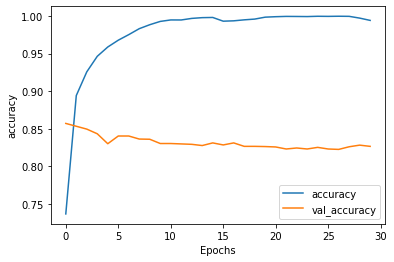

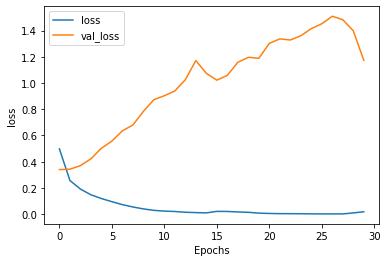

In [16]:
plot_graphs(gru_history, 'accuracy')
plot_graphs(gru_history, 'loss')

# Model 5: Convolution

Next, we will use a convolution layer to extract features. 
1. With GlobalAveragePooling1d layer to reduce the results before passing it on to the dense layers. 
2. Like the model with Flatten, this trains much faster than the ones using RNN layers like LSTM and GRU.

In [17]:
# Parameters
filters = 128
kernel_size = 5

conv_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

conv_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 6)                 774       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,149
Trainable params: 171,149
Non-trainable params: 0
________________________________________________

In [18]:
conv_history = conv_model.fit(training_padded, training_labels, epochs=num_epochs, batch_size=BATCH_SIZE,
                              validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
180/180 - 7s - loss: 0.6567 - accuracy: 0.5928 - val_loss: 0.5778 - val_accuracy: 0.7533 - 7s/epoch - 40ms/step
Epoch 2/30
180/180 - 5s - loss: 0.5046 - accuracy: 0.8007 - val_loss: 0.4746 - val_accuracy: 0.8140 - 5s/epoch - 25ms/step
Epoch 3/30
180/180 - 4s - loss: 0.4099 - accuracy: 0.8718 - val_loss: 0.4417 - val_accuracy: 0.8301 - 4s/epoch - 24ms/step
Epoch 4/30
180/180 - 5s - loss: 0.3493 - accuracy: 0.8999 - val_loss: 0.4287 - val_accuracy: 0.8310 - 5s/epoch - 26ms/step
Epoch 5/30
180/180 - 5s - loss: 0.3032 - accuracy: 0.9198 - val_loss: 0.4366 - val_accuracy: 0.8331 - 5s/epoch - 28ms/step
Epoch 6/30
180/180 - 6s - loss: 0.2678 - accuracy: 0.9341 - val_loss: 0.4392 - val_accuracy: 0.8269 - 6s/epoch - 34ms/step
Epoch 7/30
180/180 - 5s - loss: 0.2385 - accuracy: 0.9423 - val_loss: 0.4522 - val_accuracy: 0.8245 - 5s/epoch - 28ms/step
Epoch 8/30
180/180 - 5s - loss: 0.2145 - accuracy: 0.9490 - val_loss: 0.4824 - val_accuracy: 0.8272 - 5s/epoch - 25ms/step
Epoch 9/30
180/1

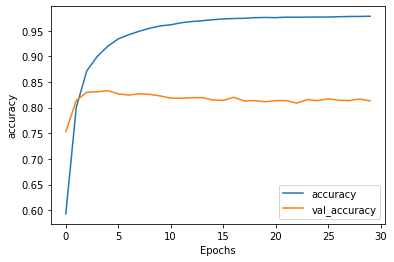

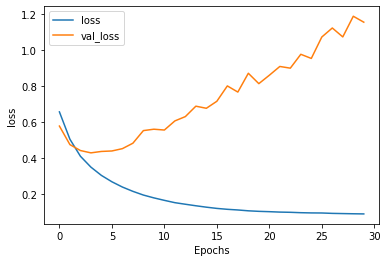

In [19]:
plot_graphs(conv_history, 'accuracy')
plot_graphs(conv_history, 'loss')

# 3 model comparision

Accuracy

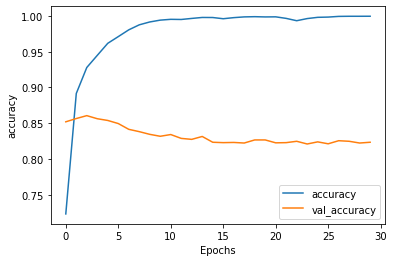

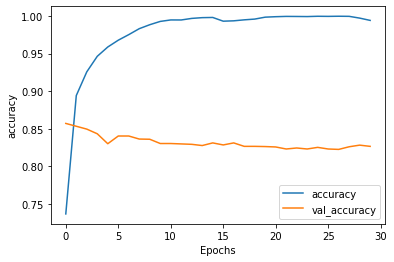

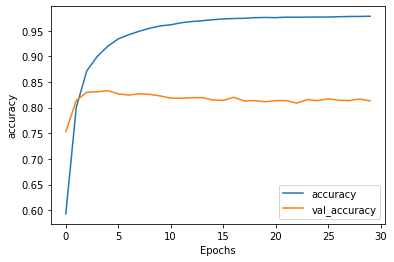

In [20]:
plot_graphs(lstm_history, "accuracy")
plot_graphs(gru_history, 'accuracy')
plot_graphs(conv_history, 'accuracy')

Loss

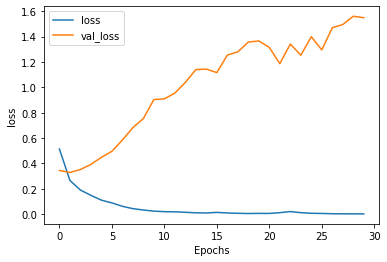

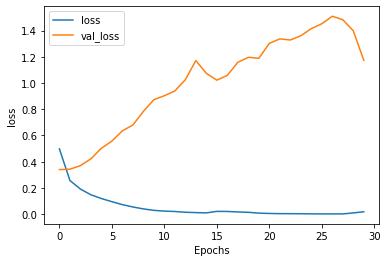

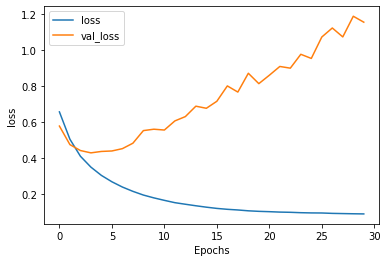

In [21]:
plot_graphs(lstm_history, "loss")
plot_graphs(gru_history, 'loss')
plot_graphs(conv_history, 'loss')

# Result - LSTM

LSTM holds slight edge over other two, and we will build multiple-levels of LSTM next (stacking)